In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
import dotenv
import pvlib

dotenv.load_dotenv()

True

In [168]:
# Werte zur Eingabe für das ganze Dokument

# Ortsdaten in Form von Latitude und Longitude
latitude = 53.550698   # Hamburg Rathausmarkt  #48.137222 München Rathaus
longitude = 9.992763   # Hamburg Rathausmarkt  #11.575277 München Rathaus

# Zeitspanne für die Datenabfrage
start_date = 20250101  # Startdatum
end_date = 20251231    # Enddatum

# Parameter für das Balkonkraftwerk
balkonkraftwerk_fläche = 1.9              # Fläche in Quadratmetern
balkonkraftwerk_azimuth = 180           # Ausrichtung nach Süden
balkonkraftwerk_tilt = 30               # Neigungswinkel in Grad
balkonkraftwerk_leistung = 450          # Leistung pro Quadratmeter in Watt eigentlich irrelevant, da nur Wirkungsgrad relevant
balkonkraftwerk_wirkungsgrad = 0.22     # Wirkungsgrad des Balkonkraftwerks

# Parameter für den Wechselrichter
wechselrichter_wirkungsgrad = 0.96      # Wirkungsgrad des Wechselrich
wechselrichter_leistungsgrenze = 800    # Maximale Leistung des Wechselrichters in Watt

# Kosten pro kWh
kosten_pro_kwh = 0.32  # Kosten pro kWh in Euro

# Eigenverbrauch in Prozent
eigenverbrauch_gering = 0.40  # 40% Eigenverbrauch
eigenverbrauch_mittel = 0.60  # 60% Eigenverbrauch
eigenverbrauch_hoch = 0.80    # 80% Eigenverbrauch

# Kosten für das Balkonkraftwerk
balkonkraftwerk_kosten_1_modul = 229 + 59    # Kosten für ein Modul in Euro + 59 Versandkosten
balkonkraftwerk_kosten_2_module = 349 + 59   # Kosten für zwei Module in Euro + 59 Versandkosten
balkonkraftwerk_kosten_3_module = 479 + 79   # Kosten für drei Module in Euro + 79 Versandkosten


In [159]:
from entsoe import EntsoePandasClient

client = EntsoePandasClient(api_key=os.getenv('TOKEN'))

start = pd.Timestamp('20250101', tz='Europe/Brussels')
end = pd.Timestamp('20260101', tz='Europe/Brussels')
country_code = 'DE_LU'  # Belgium
country_code_from = 'DE_LU'  # France
country_code_to = 'DE_LU' # Germany-Luxembourg
type_marketagreement_type = 'A01'
contract_marketagreement_type = "A01"
process_type = 'A44'
resolution = '15min'
sequence = 2

# methods that return Pandas Series
price_series = client.query_day_ahead_prices_local(country_code=country_code,
                                    sequence=sequence,
                                    start=start,
                                    end=end,
                                    resolution=resolution,)

# Resampling der Daten auf stündlich und Umwandeln des Index in Datum sowie Lokalisieren auf UTC
price_series = price_series.resample('h').mean() # Resampling auf stündlich
price_series.index = price_series.index.tz_convert('UTC') # Lokalisieren auf UTC
price_series.name = 'Price' # Spaltenname setzen

# Überprüfen der Datentypen und Ausgabe sowie Anzahl der NaN-Werte
print('Datentypen:\n', price_series.dtypes)
print('Anzahl NaN-Wert:\n', price_series.isna().sum())
print(price_series.head())

Datentypen:
 float64
Anzahl NaN-Wert:
 0
2024-12-31 23:00:00+00:00   -0.1150
2025-01-01 00:00:00+00:00   -0.5150
2025-01-01 01:00:00+00:00   -1.4775
2025-01-01 02:00:00+00:00   -2.6000
2025-01-01 03:00:00+00:00   -6.5000
Freq: h, Name: Price, dtype: float64


In [160]:
# Abruf der relevanten Daten für die Sonneneinstrahlung bei Open Meteo
# https://open-meteo.com/en/docs/historical-weather-api?

website_url_meteo = "https://archive-api.open-meteo.com/v1/archive"

# Parameter für den API-Aufruf
params = {
	"latitude": latitude,
	"longitude": longitude,
	"start_date": "2025-01-01",
	"end_date": "2025-12-31",
	"hourly": ["shortwave_radiation", "diffuse_radiation", "direct_normal_irradiance"],
}

# API-Anfrage senden
response = requests.get(website_url_meteo, params=params)

# Statuscode der Antwort ausgeben
print("Statuscode:", response.status_code)

# Antwort als JSON in Pandas DF ausgeben (falls erfolgreich)
if response.status_code == 200:
    data = response.json()
    parameter = data['hourly']
    df_meteo = pd.DataFrame({
		'Datum':pd.to_datetime(parameter['time']),
        'Global_Radiation':parameter['shortwave_radiation'],        # Watt pro m2
        'Direct_Radiation':parameter['direct_normal_irradiance'],   # Watt pro m2
        'Diffuse_Radiation':parameter['diffuse_radiation']          # Watt pro m2
	})

    # Datum als Index setzen und auf UTC lokalisieren
    df_meteo['Datum'] = pd.to_datetime(df_meteo['Datum']).dt.tz_localize('UTC')
    df_meteo.set_index('Datum', inplace=True)

    # Ausage über den erfolgreichen Abruf der Daten
    print('Daten erfolgreich im df_meteo gespeichert.')

else:
    print("Fehler beim Abrufen der Daten. Statuscode:", response.status_code)
    print("Fehlertext:", response.text)

# Schließen der Verbindung
response.close()

# Ausgabe der ersten Zeilen des DataFrames und der Datentypen sowie Prüfen auf NaN-Werte
print('Datentypen:\n', df_meteo.dtypes)
print('Anzahl NaN-Werte:\n', df_meteo.isna().sum())
print(df_meteo.head())

Statuscode: 200
Daten erfolgreich im df_meteo gespeichert.
Datentypen:
 Global_Radiation     float64
Direct_Radiation     float64
Diffuse_Radiation    float64
dtype: object
Anzahl NaN-Werte:
 Global_Radiation     0
Direct_Radiation     0
Diffuse_Radiation    0
dtype: int64
                           Global_Radiation  Direct_Radiation  \
Datum                                                           
2025-01-01 00:00:00+00:00               0.0               0.0   
2025-01-01 01:00:00+00:00               0.0               0.0   
2025-01-01 02:00:00+00:00               0.0               0.0   
2025-01-01 03:00:00+00:00               0.0               0.0   
2025-01-01 04:00:00+00:00               0.0               0.0   

                           Diffuse_Radiation  
Datum                                         
2025-01-01 00:00:00+00:00                0.0  
2025-01-01 01:00:00+00:00                0.0  
2025-01-01 02:00:00+00:00                0.0  
2025-01-01 03:00:00+00:00          

In [161]:
# Abrufen des Sonnenstands mit pvlib

# Zeitstempel für die Berechnung des Sonnenstands
times = pd.date_range(start='2025-01-01', end='2025-12-31', freq='h', tz='UTC')

# Berechnung des Sonnenstands
solpos = pvlib.solarposition.get_solarposition(times, latitude, longitude)

# Umwandeln in DataFrame, Setzen des Index auf Datum und Lokalisieren auf UTC
df_solar_position = solpos.copy()
df_solar_position.index.name = 'Datum'
df_solar_position.index = df_solar_position.index.tz_convert('UTC')


# Ausgabe der Datentypen, der Anzahl der NaN-Werte und der ersten Zeilen des DataFrames
print('Datentypen:\n', df_solar_position.dtypes)
print('Anzahl NaN-Werte:\n', df_solar_position.isna().sum())
print(df_solar_position.head())

Datentypen:
 apparent_zenith       float64
zenith                float64
apparent_elevation    float64
elevation             float64
azimuth               float64
equation_of_time      float64
dtype: object
Anzahl NaN-Werte:
 apparent_zenith       0
zenith                0
apparent_elevation    0
elevation             0
azimuth               0
equation_of_time      0
dtype: int64
                           apparent_zenith      zenith  apparent_elevation  \
Datum                                                                        
2025-01-01 00:00:00+00:00       148.676243  148.676243          -58.676243   
2025-01-01 01:00:00+00:00       144.426500  144.426500          -54.426500   
2025-01-01 02:00:00+00:00       137.604057  137.604057          -47.604057   
2025-01-01 03:00:00+00:00       129.400428  129.400428          -39.400428   
2025-01-01 04:00:00+00:00       120.605987  120.605987          -30.605987   

                           elevation    azimuth  equation_of_time  
Da

In [6]:
# Kombinieren der Daten aus df_meteo und df_solar_position und price_series über den Index Datum als Schlüssel
df = df_meteo.join([df_solar_position, price_series.to_frame('Price')], how='inner')

# Ausgabe der ersten Zeilen des neuen DataFrames
print(df.head())

                           Global_Radiation  Direct_Radiation  \
2025-01-01 00:00:00+00:00               0.0               0.0   
2025-01-01 01:00:00+00:00               0.0               0.0   
2025-01-01 02:00:00+00:00               0.0               0.0   
2025-01-01 03:00:00+00:00               0.0               0.0   
2025-01-01 04:00:00+00:00               0.0               0.0   

                           Diffuse_Radiation  apparent_zenith      zenith  \
2025-01-01 00:00:00+00:00                0.0       148.676243  148.676243   
2025-01-01 01:00:00+00:00                0.0       144.426500  144.426500   
2025-01-01 02:00:00+00:00                0.0       137.604057  137.604057   
2025-01-01 03:00:00+00:00                0.0       129.400428  129.400428   
2025-01-01 04:00:00+00:00                0.0       120.605987  120.605987   

                           apparent_elevation  elevation    azimuth  \
2025-01-01 00:00:00+00:00          -58.676243 -58.676243  16.320901   
2025

In [64]:
# Erstellen einer Funktion die die Summe der Globarstrahlung auf der Fläche des Balkonkraftwerks für den kompletten DataFrame berechnet
def calculate_solar_yield(df, balkonkraftwerk_tilt, balkonkraftwerk_azimuth, balkonkraftwerk_fläche, balkonkraftwerk_wirkungsgrad):
    '''
    Berechnet den Solarertrag des Balkonkraftwerks unter Berücksichtigung der Neigung und Ausrichtung.
    
    Args:
    df: DataFrame mit den Spalten 'Direct_Radiation', 'Global_Radiation', 'Diffuse_Radiation', 'apparent_zenith' und 'azimuth'
    balkonkraftwerk_tilt: Neigungswinkel des Balkonkraftwerks in Grad
    balkonkraftwerk_azimuth: Ausrichtung des Balkonkraftwerks in Grad (Azimut)
    balkonkraftwerk_fläche: Fläche des Balkonkraftwerks in Quadratmetern
    balkonkraftwerk_wirkungsgrad: Wirkungsgrad des Balkonkraftwerks

    Returns: df mit den Spalten 'POA_Global_calculated' und 'solar_yield_Wh'
    '''

    # Berechnung der Globalstrahlung auf der Fläche des Balkonkraftwerks unter Berücksichtigung der Neigung und Ausrichtung
    df['POA_Global_calculated'] = pvlib.irradiance.get_total_irradiance(
        surface_tilt=balkonkraftwerk_tilt,          # Neigungswinkel in Grad
        surface_azimuth=balkonkraftwerk_azimuth,    # Ausrichtung in Grad (Azimut)
        dni=df['Direct_Radiation'],                 # Direktstrahlung in Watt pro m2
        ghi=df['Global_Radiation'],                 # Globalstrahlung in Watt pro m2
        dhi=df['Diffuse_Radiation'],                # Diffusstrahlung in Watt pro m2
        solar_zenith=df['apparent_zenith'],         # Zenithwinkel der Sonne in Grad
        solar_azimuth=df['azimuth']                 # Azimutwinkel der Sonne in Grad
    )['poa_global']

    # Berechnung der Leistung des Balkonkraftwerks unter Berücksichtigung der Fläche, des Wirkungsgrads
    # und der Globalstrahlung auf der Fläche
    df['solar_yield_Wh'] = df['POA_Global_calculated'] * balkonkraftwerk_fläche * balkonkraftwerk_wirkungsgrad
    return df

In [65]:
# Erstellen einer Funktion für die weiteren Optimierungsaufgaben unter der NB 800 Wh Einspeisung pro Stunde
def optimize_solar_yield(df, balkonkraftwerk_tilt, balkonkraftwerk_azimuth, balkonkraftwerk_fläche, balkonkraftwerk_wirkungsgrad):
    '''
    Dient als Funktion für die weitern Optimierungsaufgaben und berechnet die Summe der Solarerträge für die entsprechenden Args.
    Nebenbedingung ist das ein Balkonkraftwerk nicht mehr als 800 Wh einspeisen darf. 
    
    Args:
    df: DataFrame mit den Spalten 'Direct_Radiation', 'Global_Radiation', 'Diffuse_Radiation', 'apparent_zenith' und 'azimuth'
    balkonkraftwerk_tilt: Neigungswinkel des Balkonkraftwerks in Grad
    balkonkraftwerk_azimuth: Ausrichtung des Balkonkraftwerks in Grad (Azimut)
    balkonkraftwerk_fläche: Fläche des Balkonkraftwerks in Quadratmetern
    balkonkraftwerk_wirkungsgrad: Wirkungsgrad des Balkonkraftwerks

    Returns: Summe der Solarerträge in Wh unter Berücksichtung der Nebenbedinung von 800 Wh Einspeisung pro Stunde
    '''

    # Berechnung der Globalstrahlung auf der Fläche des Balkonkraftwerks unter Berücksichtigung der Neigung und Ausrichtung
    df['POA_Global_calculated'] = pvlib.irradiance.get_total_irradiance(
        surface_tilt=balkonkraftwerk_tilt,          # Neigungswinkel in Grad
        surface_azimuth=balkonkraftwerk_azimuth,    # Ausrichtung in Grad (Azimut)
        dni=df['Direct_Radiation'],                 # Direktstrahlung in Watt pro m2
        ghi=df['Global_Radiation'],                 # Globalstrahlung in Watt pro m2
        dhi=df['Diffuse_Radiation'],                # Diffusstrahlung in Watt pro m2
        solar_zenith=df['apparent_zenith'],         # Zenithwinkel der Sonne in Grad
        solar_azimuth=df['azimuth']                 # Azimutwinkel der Sonne in Grad
    )['poa_global']

    # Berechnung der Leistung des Balkonkraftwerks unter Berücksichtigung der Fläche, des Wirkungsgrads
    # und der Globalstrahlung auf der Fläche
    df['solar_yield_Wh'] = df['POA_Global_calculated'] * balkonkraftwerk_fläche * balkonkraftwerk_wirkungsgrad

    # Anwendung der Nebenbedingung: Maximal 800 Wh pro Stunde
    df['solar_yield_Wh'] = df['solar_yield_Wh'].clip(upper=800)

    return sum(df['solar_yield_Wh'])

<Axes: title={'center': 'Berechneter Solarertrag des Balkonkraftwerks (Wh)'}, xlabel='Datum', ylabel='Solarertrag (Wh)'>

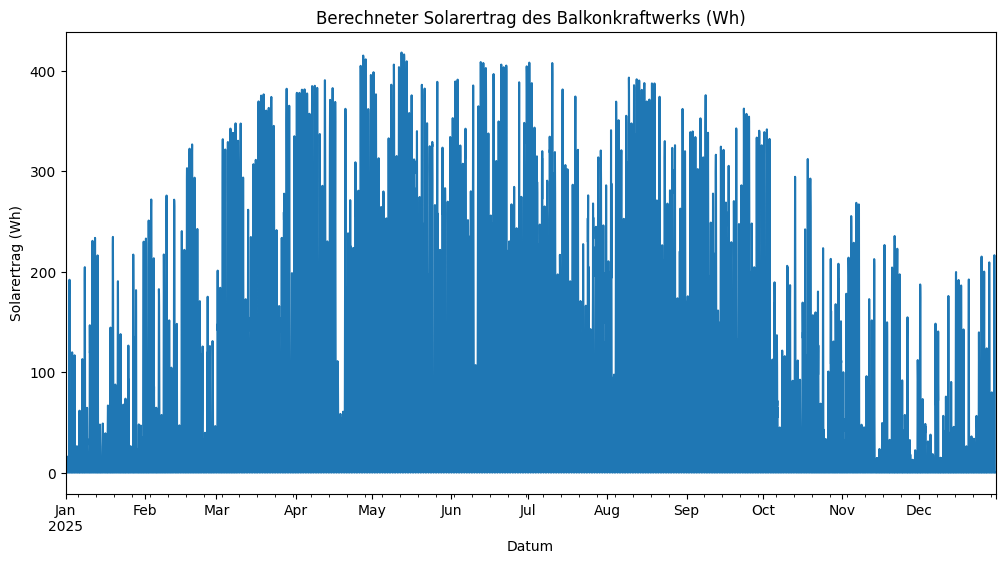

In [162]:
# Berechnung des Solarertrags für den gesamten DataFrame
df = calculate_solar_yield(df,
                           balkonkraftwerk_tilt,
                           balkonkraftwerk_azimuth,
                           balkonkraftwerk_fläche,
                           balkonkraftwerk_wirkungsgrad,
                          ) 

# Plotten der berechneten Solarerträge über die Zeit
df['solar_yield_Wh'].plot(figsize=(12, 6),
                           title='Berechneter Solarertrag des Balkonkraftwerks (Wh)',
                           ylabel='Solarertrag (Wh)',
                           xlabel='Datum')

In [12]:
print(df['solar_yield_Wh'].sum())

577574.053803757


Nachfolgend werden 3 Optimierungen durchgeführt:
Fläche für 1 Modul
Fläche für 2 Module
Fläche für 3 Module
Die Module werden alle gleich ausgerichtet und sind dementsprechend nicht unabhägig von einandern.

In [182]:
# Optimierung der Neigung und Ausrichtung des Balkonkraftwerks mittels Parameter-Grid-Suche

# Importieren der Funktion ParameterGrid aus sklearn, Verwendung der Brute-Force-Methode
from sklearn.model_selection import ParameterGrid

# 1. Leere Liste für die optimalen Ergebnisse aller Flächen
optimal_results = []  

# 2. Schleife für 3 verschiedene Flächen
balkonkraftwerk_fläche_values = [
    balkonkraftwerk_fläche,
    balkonkraftwerk_fläche * 2,
    balkonkraftwerk_fläche * 3
]

for fläche in balkonkraftwerk_fläche_values:
    # Definieren der Parameter
    param_grid = {
        'balkonkraftwerk_tilt': range(0, 51, 1),          # Neigung in 1°-Schritten
        'balkonkraftwerk_azimuth': range(0, 360, 1),     # Azimut in 1°-Schritten
        'balkonkraftwerk_fläche': [fläche],
        'balkonkraftwerk_wirkungsgrad': [balkonkraftwerk_wirkungsgrad]
    }

    # Leere Liste für die Ergebnisse der aktuellen Fläche
    results = []

    # Durchläufe alle Kombinationen
    for params in ParameterGrid(param_grid):
        solar_yield_sum = optimize_solar_yield(
            df.copy(),
            balkonkraftwerk_tilt=params['balkonkraftwerk_tilt'],
            balkonkraftwerk_azimuth=params['balkonkraftwerk_azimuth'],
            balkonkraftwerk_fläche=params['balkonkraftwerk_fläche'],
            balkonkraftwerk_wirkungsgrad=params['balkonkraftwerk_wirkungsgrad']
        )
        results.append({
            'Neigung': params['balkonkraftwerk_tilt'],
            'Azimut': params['balkonkraftwerk_azimuth'],
            'Gesamtertrag_Wh': solar_yield_sum
        })

    # Erstelle den DataFrame für die aktuelle Fläche
    df_result_grid_search = pd.DataFrame(results)

    # Beste Kombination finden und in der Liste speichern
    if not df_result_grid_search.empty:
        best_combination = df_result_grid_search.loc[df_result_grid_search['Gesamtertrag_Wh'].idxmax()]
        optimal_results.append({
            'Fläche_m²': fläche,
            'Neigung_°': best_combination['Neigung'],
            'Azimut_°': best_combination['Azimut'],
            'Gesamtertrag_Wh': best_combination['Gesamtertrag_Wh']
        })

# 3. Erstelle den finalen DataFrame mit allen optimalen Ergebnissen
df_optimal_results_1 = pd.DataFrame(optimal_results)

# 4. Ergebnisse anzeigen
print("\nOptimale Winkel für verschiedene Flächen:")
print(df_optimal_results_1)


Optimale Winkel für verschiedene Flächen:
   Fläche_m²  Neigung_°  Azimut_°  Gesamtertrag_Wh
0        1.9       41.0     188.0     5.857421e+05
1        3.8       41.0     188.0     1.170935e+06
2        5.7       39.0     191.0     1.617675e+06


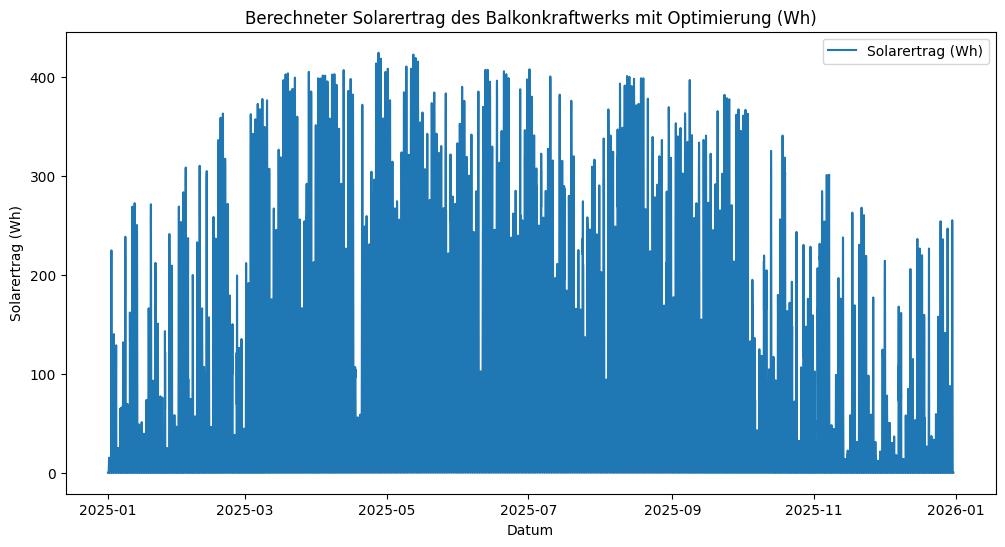

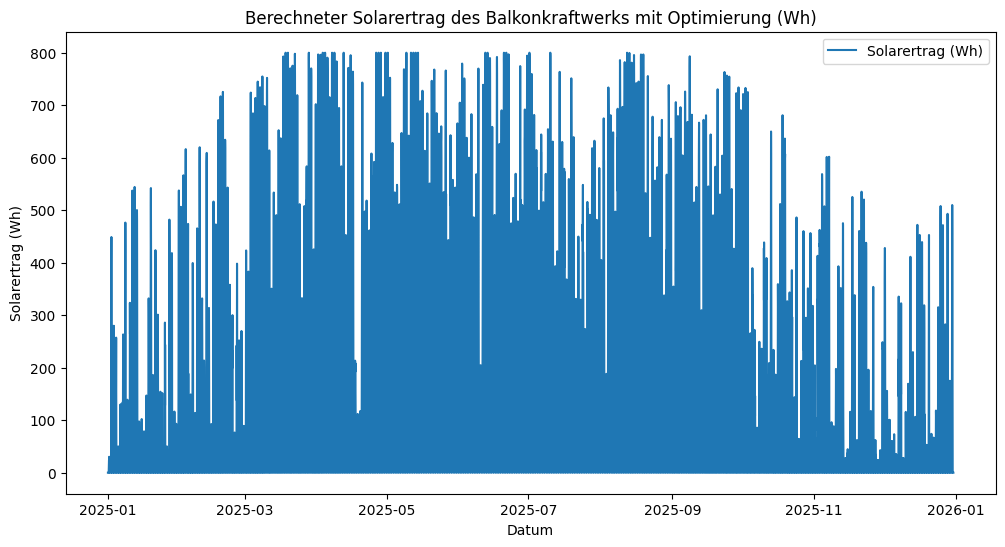

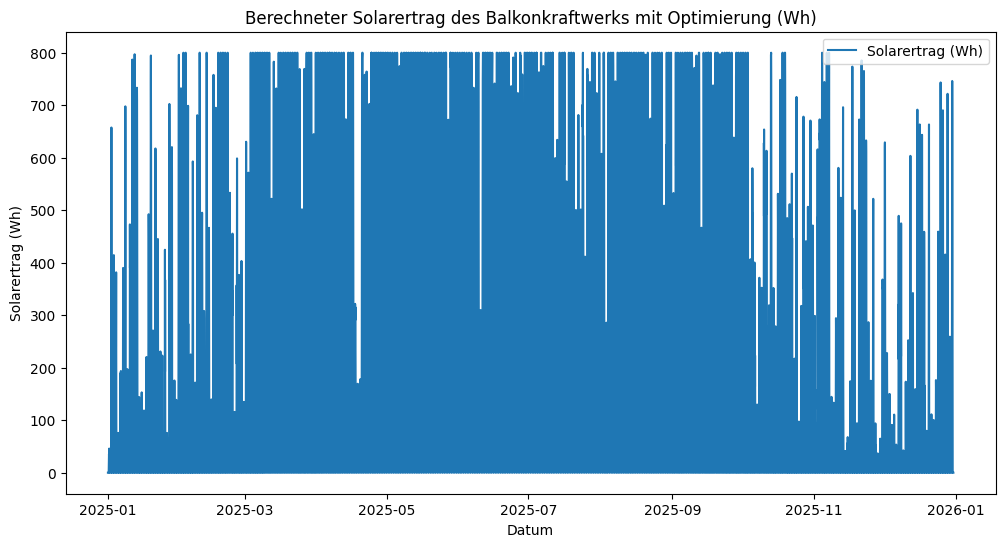

In [164]:
# Plotten der Ergebnisse aus df_optimal_results_1 unter Berechnung mittels calculate_solar_yield für jede Zeile des DataFrames
for index, row in df_optimal_results_1.iterrows():
    df_optimal_results_1_plot = calculate_solar_yield(df,
                           balkonkraftwerk_tilt=row['Neigung_°'],
                           balkonkraftwerk_azimuth=row['Azimut_°'],
                           balkonkraftwerk_fläche=row['Fläche_m²'],
                           balkonkraftwerk_wirkungsgrad=balkonkraftwerk_wirkungsgrad,
                          )
    df_optimal_results_1_plot['solar_yield_Wh'] = df_optimal_results_1_plot['solar_yield_Wh'].clip(upper=800)

    # plotten von solar_yield_Wh
    plt.figure(figsize=(12, 6))
    plt.plot(df_optimal_results_1_plot.index, df_optimal_results_1_plot['solar_yield_Wh'], label='Solarertrag (Wh)')
    plt.title('Berechneter Solarertrag des Balkonkraftwerks mit Optimierung (Wh)')
    plt.ylabel('Solarertrag (Wh)')
    plt.xlabel('Datum')
    plt.legend()
    plt.show() 
    


--- Optimale Parameter für 1 Modul ---
Neigung: 41.0°, Azimut: 188.0°
Maximaler Ertrag: 585,742.13 Wh


/var/folders/c5/491yhz3s1y93gvqdkz7t62p00000gn/T/ipykernel_68137/1491089200.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


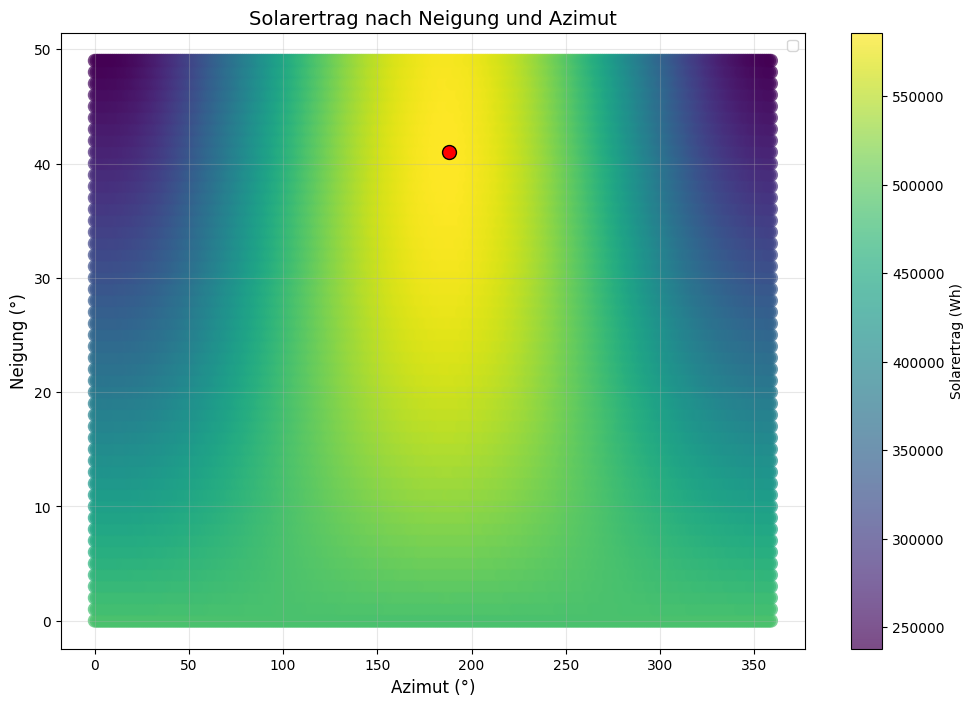

In [189]:
from sklearn.model_selection import ParameterGrid

# 1. Definiere die Parameter für 1 Modul (eingeschränkter Bereich für bessere Visualisierung)
param_grid = {
    'balkonkraftwerk_tilt': range(0, 50, 1),      # Neigung: 0–50°
    'balkonkraftwerk_azimuth': range(0, 360, 1), # Azimut: 0°–360°
    'balkonkraftwerk_fläche': [balkonkraftwerk_fläche],
    'balkonkraftwerk_wirkungsgrad': [balkonkraftwerk_wirkungsgrad]
}

# 2. Leere Liste für alle Ergebnisse
results = []

# 3. Durchläufe alle Kombinationen und speichere Ergebnisse
for params in ParameterGrid(param_grid):
    solar_yield = optimize_solar_yield(
        df.copy(),
        balkonkraftwerk_tilt=params['balkonkraftwerk_tilt'],
        balkonkraftwerk_azimuth=params['balkonkraftwerk_azimuth'],
        balkonkraftwerk_fläche=params['balkonkraftwerk_fläche'],
        balkonkraftwerk_wirkungsgrad=params['balkonkraftwerk_wirkungsgrad']
    )
    results.append({
        'Neigung': params['balkonkraftwerk_tilt'],
        'Azimut': params['balkonkraftwerk_azimuth'],
        'Gesamtertrag_Wh': solar_yield
    })

# 4. Erstelle DataFrame mit allen Ergebnissen
df_results = pd.DataFrame(results)

# 5. Finde die beste Kombination
best_combination = df_results.loc[df_results['Gesamtertrag_Wh'].idxmax()]

# 6. Ergebnisse anzeigen
print("\n--- Optimale Parameter für 1 Modul ---")
print(f"Neigung: {best_combination['Neigung']}°, Azimut: {best_combination['Azimut']}°")
print(f"Maximaler Ertrag: {best_combination['Gesamtertrag_Wh']:,.2f} Wh")

# 7. Scatter-Plot aller Kombinationen
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    df_results['Azimut'],          # x-Achse: Azimut
    df_results['Neigung'],         # y-Achse: Neigung
    c=df_results['Gesamtertrag_Wh'], # Farbe: Solarertrag
    cmap='viridis',                # Farbmap (viridis, plasma, magma)
    s=100,                         # Punktgröße
    alpha=0.7,                     # Transparenz
    edgecolors='none'              # Keine Ränder
)

# 8. Markiere die beste Kombination
plt.scatter(
    best_combination['Azimut'],
    best_combination['Neigung'],
    edgecolors='black',            # Schwarzer Rand
    linewidth=1,
    c='red',                       # Rot für beste Kombination
    s=100,                         # Größerer Punkt

)

# 9. Titel und Achsen
plt.title('Solarertrag nach Neigung und Azimut', fontsize=14)
plt.xlabel('Azimut (°)', fontsize=12)
plt.ylabel('Neigung (°)', fontsize=12)
plt.colorbar(scatter, label='Solarertrag (Wh)')  # Farbbar

# 10. Grid und Legende
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


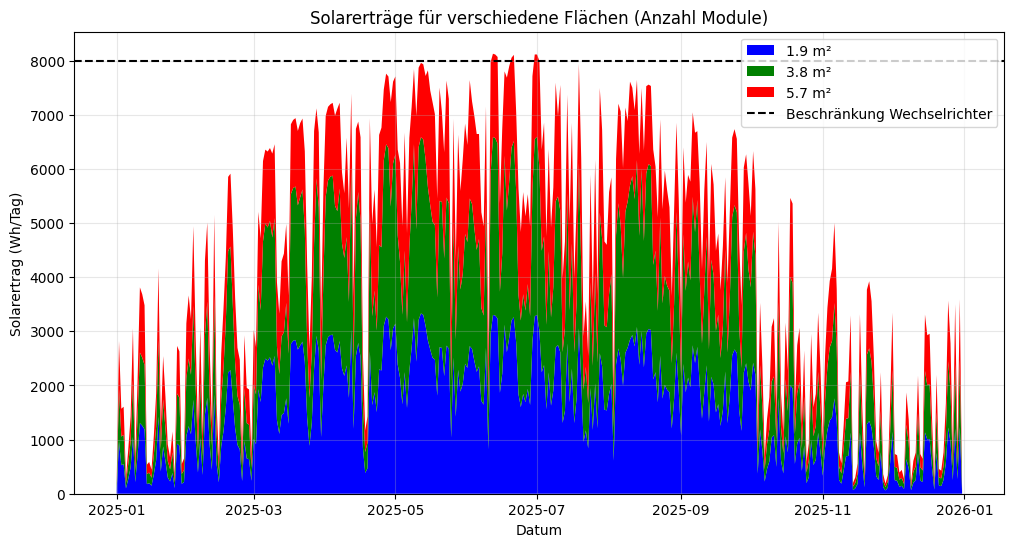

In [177]:
# 1. DataFrame mit den stündlichen Werten für alle drei Flächen erstellen
df_combined = pd.DataFrame(index=df.index)

# 2. Solarerträge für jede Fläche berechnen und speichern
for index, row in df_optimal_results_1.iterrows():
    df_temp = calculate_solar_yield(
        df.copy(),
        balkonkraftwerk_tilt=row['Neigung_°'],
        balkonkraftwerk_azimuth=row['Azimut_°'],
        balkonkraftwerk_fläche=row['Fläche_m²'],
        balkonkraftwerk_wirkungsgrad=balkonkraftwerk_wirkungsgrad
    )
    df_temp['solar_yield_Wh'] = df_temp['solar_yield_Wh'].clip(upper=800)
    df_combined[f'Fläche_{index+1}'] = df_temp['solar_yield_Wh']

# 3. Sortiere die Flächen nach Größe (kleinste zuerst)
df_optimal_results_1 = df_optimal_results_1.sort_values(by='Fläche_m²', ascending=True)

# 4. Aggregiere die stündlichen Werte auf Tageswerte (Summe pro Tag)
df_daily = df_combined.resample('D').sum()

# 5. Berechne die Differenzen für das gestapelte Diagramm (täglich)
df_daily['Fläche_2_diff'] = df_daily['Fläche_2'] - df_daily['Fläche_1']
df_daily['Fläche_3_diff'] = df_daily['Fläche_3'] - df_daily['Fläche_2']

# 6. Korrigiere negative Differenzen (falls nötig)
df_daily['Fläche_2_diff'] = df_daily['Fläche_2_diff'].clip(lower=0)
df_daily['Fläche_3_diff'] = df_daily['Fläche_3_diff'].clip(lower=0)

# 7. Erstelle das gestapelte Liniendiagramm (täglich)
plt.figure(figsize=(12, 6))

# 8. Plotte die Flächen als gestapelte Differenzen (täglich)
plt.stackplot(
    df_daily.index,
    df_daily['Fläche_1'],          # Kleinste Fläche (unten)
    df_daily['Fläche_2_diff'],     # Differenz mittlere Fläche
    df_daily['Fläche_3_diff'],     # Differenz größte Fläche
    colors=['blue', 'green', 'red'],
    labels=[
        f"{df_optimal_results_1.iloc[0]['Fläche_m²']} m²",
        f"{df_optimal_results_1.iloc[1]['Fläche_m²']} m² (Differenz)",
        f"{df_optimal_results_1.iloc[2]['Fläche_m²']} m² (Differenz)"
    ],
    alpha=1
)

# 9. 800-Wh-Grenze als gestrichelte Linie (täglich)
plt.axhline(y=8000, color='black', linestyle='--', label='800 Wh Grenze')

# 10. Titel und Achsenbeschriftung
plt.title('Solarerträge für verschiedene Flächen (Anzahl Module)')
plt.ylabel('Solarertrag (Wh/Tag)')
plt.xlabel('Datum')

# 11. Legende mit Neigung/Azimut
legend_labels = [
    f"{df_optimal_results_1.iloc[0]['Fläche_m²']} m²",
    f"{df_optimal_results_1.iloc[1]['Fläche_m²']} m²",
    f"{df_optimal_results_1.iloc[2]['Fläche_m²'].round(1)} m²",
    'Beschränkung Wechselrichter'
]

plt.legend(legend_labels, loc='upper right')

# 12. Grid für bessere Lesbarkeit
plt.grid(True, alpha=0.3)

# 13. Diagramm anzeigen
plt.show()

Fehler: Unbekannte Fläche in df_optimal_results_1_total
Fläche_m²                       float64
Neigung_°                       float64
Azimut_°                        float64
Gesamtertrag_Wh                 float64
Gesamtertrag_kWh                float64
Eigenverbrauch                 category
Finanzieller_Ertrag             float64
Amortisationszeitraum_Jahre     float64
dtype: object


,Fläche_m²,Neigung_°,Azimut_°,Gesamtertrag_Wh,Gesamtertrag_kWh,Eigenverbrauch,Finanzieller_Ertrag,Amortisationszeitraum_Jahre
0,1.9,41.0,188.0,5.857421e+05,585.742129,0.4,74.974993,3.841281
1,1.9,41.0,188.0,5.857421e+05,585.742129,0.6,112.462489,2.560854
2,1.9,41.0,188.0,5.857421e+05,585.742129,0.8,149.949985,1.920640
3,3.8,41.0,188.0,1.170935e+06,1170.934728,0.4,149.879645,2.722184
4,3.8,41.0,188.0,1.170935e+06,1170.934728,0.6,224.819468,1.814789
5,3.8,41.0,188.0,1.170935e+06,1170.934728,0.8,299.759290,1.361092
6,5.7,39.0,191.0,1.617675e+06,1617.674707,0.4,207.062362,2.694840
7,5.7,39.0,191.0,1.617675e+06,1617.674707,0.6,310.593544,1.796560
8,5.7,39.0,191.0,1.617675e+06,1617.674707,0.8,414.124725,1.347420


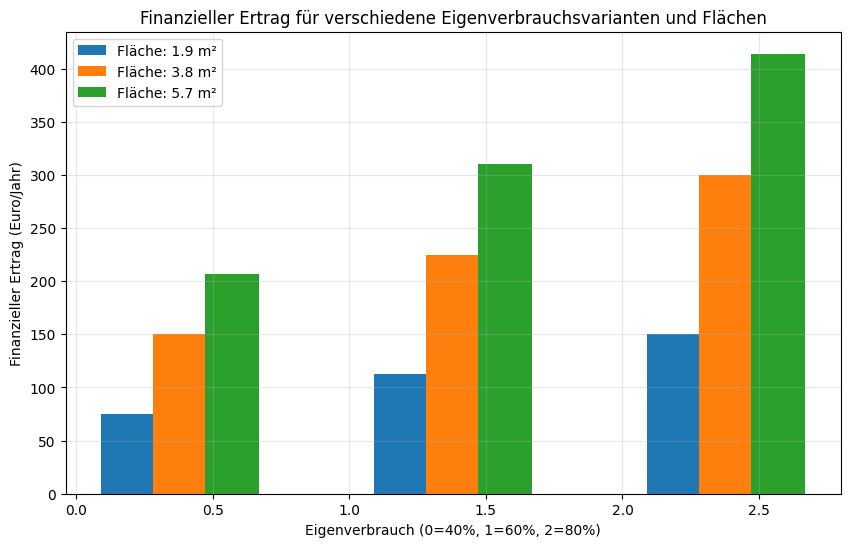

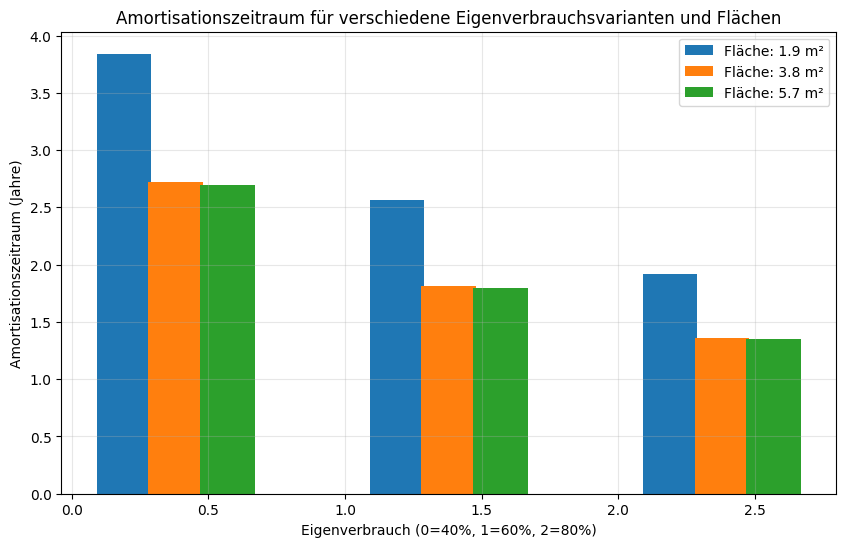

In [183]:
# Berechnen des Gesamtertrages in kWh für jede Zeile im DataFrame
df_optimal_results_1['Gesamtertrag_kWh'] = df_optimal_results_1['Gesamtertrag_Wh'] / 1000

# Leeren DataFrame für das erweiterte Ergebnis nach Eigenverbrauch erstellen
df_optimal_results_1_total = pd.DataFrame()

# Für jede Zeile im ursprünglichen DataFrame drei neue Zeilen mit den Eigenverbrauchsvarianten erstellen
for _, row in df_optimal_results_1.iterrows():
    for eigenverbrauch in [eigenverbrauch_gering, eigenverbrauch_mittel, eigenverbrauch_hoch]:
        new_row = row.copy()
        new_row['Eigenverbrauch'] = eigenverbrauch
        new_row['Finanzieller_Ertrag'] = row['Gesamtertrag_kWh'] * kosten_pro_kwh * eigenverbrauch
        df_optimal_results_1_total = pd.concat([df_optimal_results_1_total, new_row.to_frame().T], ignore_index=True)

# Umwandeln der Eigenverbrauchs-Spalte in den Datentyp 'category' für bessere Übersicht und Performance
df_optimal_results_1_total['Eigenverbrauch'] = df_optimal_results_1_total['Eigenverbrauch'].astype('category')

# Berechnen des Amortisationszeitraums in Jahren für jede Zeile im DataFrame basierend auf der Fläche und den Kosten
for row in df_optimal_results_1_total.itertuples():
    if df_optimal_results_1_total.loc[row.Index, 'Fläche_m²'] == balkonkraftwerk_fläche:
        df_optimal_results_1_total.loc[row.Index, 'Amortisationszeitraum_Jahre'] = balkonkraftwerk_kosten_1_modul / df_optimal_results_1_total.loc[row.Index, 'Finanzieller_Ertrag']
    elif df_optimal_results_1_total.loc[row.Index, 'Fläche_m²'] == balkonkraftwerk_fläche * 2:
        df_optimal_results_1_total.loc[row.Index, 'Amortisationszeitraum_Jahre'] = balkonkraftwerk_kosten_2_module / df_optimal_results_1_total.loc[row.Index, 'Finanzieller_Ertrag']
    elif df_optimal_results_1_total.loc[row.Index, 'Fläche_m²'] == balkonkraftwerk_fläche * 3:
        df_optimal_results_1_total.loc[row.Index, 'Amortisationszeitraum_Jahre'] = balkonkraftwerk_kosten_3_module / df_optimal_results_1_total.loc[row.Index, 'Finanzieller_Ertrag']
else:
    print("Fehler: Unbekannte Fläche in df_optimal_results_1_total")

print(df_optimal_results_1_total.dtypes)
display(df_optimal_results_1_total)

# Plotten des finanziellen Ertrags für die Eigenverbrauchsvarianten für jede Fläche als Balkendiagramm
plt.figure(figsize=(10, 6))
for fläche in df_optimal_results_1_total['Fläche_m²'].unique():
    subset = df_optimal_results_1_total[df_optimal_results_1_total['Fläche_m²'] == fläche]
    plt.bar(subset['Eigenverbrauch'].cat.codes + (fläche / 10), subset['Finanzieller_Ertrag'], width=0.2, label=f'Fläche: {fläche.round(1)} m²')
plt.xlabel('Eigenverbrauch (0=40%, 1=60%, 2=80%)')
plt.ylabel('Finanzieller Ertrag (Euro/Jahr)')
plt.title('Finanzieller Ertrag für verschiedene Eigenverbrauchsvarianten und Flächen')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plotten des Amortisationszeitraums für die Eigenverbrauchsvarianten für jede Fläche als Balkendiagramm
plt.figure(figsize=(10, 6))
for fläche in df_optimal_results_1_total['Fläche_m²'].unique():
    subset = df_optimal_results_1_total[df_optimal_results_1_total['Fläche_m²'] == fläche]
    plt.bar(subset['Eigenverbrauch'].cat.codes + (fläche / 10), subset['Amortisationszeitraum_Jahre'], width=0.2, label=f'Fläche: {fläche.round(1)} m²')
plt.xlabel('Eigenverbrauch (0=40%, 1=60%, 2=80%)')
plt.ylabel('Amortisationszeitraum (Jahre)')
plt.title('Amortisationszeitraum für verschiedene Eigenverbrauchsvarianten und Flächen')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

 The best solution found:                                                                           
 [ 42. 189.  40. 191.]

 Objective function:
 -1171212.681671816


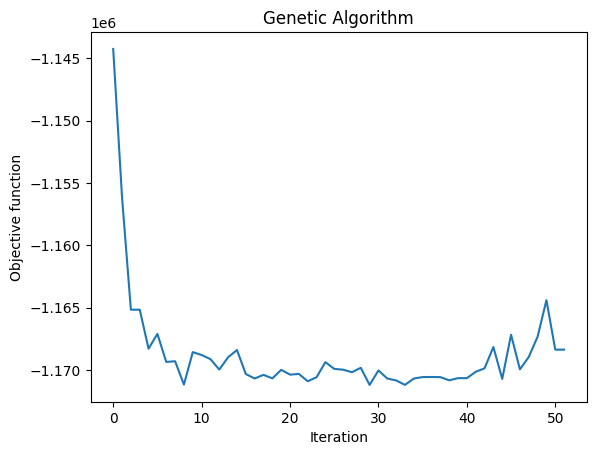


--- Optimale Parameter ---
Modul 1: Neigung = 42°, Azimut = 189°
Modul 2: Neigung = 40°, Azimut = 191°
Kombinierter Gesamtertrag: 1,171,212.68 Wh


In [125]:
from geneticalgorithm import geneticalgorithm as ga

# Fitnessfunktion (zu maximieren)
def fitness_function(params):
    neigung1, azimuth1, neigung2, azimuth2 = params

    # Solarertrag für Modul 1 berechnen
    ertrag1 = optimize_solar_yield(
        df.copy(),
        balkonkraftwerk_tilt=int(neigung1),
        balkonkraftwerk_azimuth=int(azimuth1),
        balkonkraftwerk_fläche=balkonkraftwerk_fläche,
        balkonkraftwerk_wirkungsgrad=balkonkraftwerk_wirkungsgrad
    )

    # Solarertrag für Modul 2 berechnen
    ertrag2 = optimize_solar_yield(
        df.copy(),
        balkonkraftwerk_tilt=int(neigung2),
        balkonkraftwerk_azimuth=int(azimuth2),
        balkonkraftwerk_fläche=balkonkraftwerk_fläche,
        balkonkraftwerk_wirkungsgrad=balkonkraftwerk_wirkungsgrad
    )

    # Kombinierter Ertrag (Fitness-Wert, zu maximieren)
    return -(ertrag1 + ertrag2)  # Negativ, weil GA minimiert

# Variablengrenzen
varbound = np.array([
    [0, 50],   # Neigung Modul 1 (0–50°)
    [0, 360],  # Azimut Modul 1 (0–360°)
    [0, 50],   # Neigung Modul 2 (0–50°)
    [0, 360]   # Azimut Modul 2 (0–360°)
])

# Variablentyp als NumPy-Array
vartype = np.array(['int', 'int', 'int', 'int'], dtype=object)

# Algorithmusparameter (mit elit_ratio=0)
algorithm_param = {
    'max_num_iteration': 100,
    'population_size': 300,
    'mutation_probability': 0.2,
    'crossover_probability': 0.7,
    'parents_portion': 0.3,
    'crossover_type': 'uniform',
    'max_iteration_without_improv': 20,
    'elit_ratio': 0  # Explizit hinzugefügt, um den KeyError zu vermeiden
}

# Modell erstellen und ausführen
model = ga(
    function=fitness_function,
    dimension=4,
    variable_type_mixed=vartype,
    variable_boundaries=varbound,
    algorithm_parameters=algorithm_param
)

model.run()

# Ergebnis extrahieren
best_params = model.output_dict['variable']
best_neigung1, best_azimuth1, best_neigung2, best_azimuth2 = map(int, best_params)
best_ertrag = -model.output_dict['function']

# Ausgabe
print("\n--- Optimale Parameter ---")
print(f"Modul 1: Neigung = {best_neigung1}°, Azimut = {best_azimuth1}°")
print(f"Modul 2: Neigung = {best_neigung2}°, Azimut = {best_azimuth2}°")
print(f"Kombinierter Gesamtertrag: {best_ertrag:,.2f} Wh")

# Optional: Konvergenzplot (falls convergence_curve aktiviert ist)
if 'convergence_curve' in model.output_dict:
    import matplotlib.pyplot as plt
    plt.plot(-np.array(model.output_dict['convergence_curve']), label='Beste Fitness')
    plt.xlabel('Iteration')
    plt.ylabel('Solarertrag (Wh)')
    plt.title('Konvergenz des genetischen Algorithmus')
    plt.legend()
    plt.grid(True)
    plt.show()


In [167]:
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

# 1. Definiere die Parameter mit deinen gewünschten Bereichen
param_grid = {
    'tilt_1': range(35, 43, 1),      # Neigung Modul 1: 35° bis 42° (8 Werte)
    'azimuth_1': range(180, 200, 2), # Azimut Modul 1: 180° bis 198° (10 Werte)
    'tilt_2': range(35, 43, 1),      # Neigung Modul 2: 35° bis 42° (8 Werte)
    'azimuth_2': range(180, 200, 2)  # Azimut Modul 2: 180° bis 198° (10 Werte)
}

# 2. Leere Liste für die Ergebnisse
results = []

# 3. Durchläufe alle Kombinationen (8 × 10 × 8 × 10 = 6.400 Iterationen)
for params in tqdm(ParameterGrid(param_grid), total=len(list(ParameterGrid(param_grid)))):
    # Berechne Solarertrag für Modul 1
    ertrag1 = optimize_solar_yield(
        df.copy(),
        balkonkraftwerk_tilt=params['tilt_1'],
        balkonkraftwerk_azimuth=params['azimuth_1'],
        balkonkraftwerk_fläche=balkonkraftwerk_fläche,
        balkonkraftwerk_wirkungsgrad=balkonkraftwerk_wirkungsgrad
    )

    # Berechne Solarertrag für Modul 2
    ertrag2 = optimize_solar_yield(
        df.copy(),
        balkonkraftwerk_tilt=params['tilt_2'],
        balkonkraftwerk_azimuth=params['azimuth_2'],
        balkonkraftwerk_fläche=balkonkraftwerk_fläche,
        balkonkraftwerk_wirkungsgrad=balkonkraftwerk_wirkungsgrad
    )

    # Speichere die Kombination und den Gesamtertrag
    results.append({
        'tilt_1': params['tilt_1'],
        'azimuth_1': params['azimuth_1'],
        'tilt_2': params['tilt_2'],
        'azimuth_2': params['azimuth_2'],
        'Gesamtertrag_Wh': ertrag1 + ertrag2
    })

# 4. Erstelle DataFrame und finde die beste Kombination
df_results = pd.DataFrame(results)
best_combination = df_results.loc[df_results['Gesamtertrag_Wh'].idxmax()]

# 5. Ergebnisse anzeigen
print("\n--- Optimale Parameter für zwei Module ---")
print(f"Modul 1: Neigung = {best_combination['tilt_1']}°, Azimut = {best_combination['azimuth_1']}°")
print(f"Modul 2: Neigung = {best_combination['tilt_2']}°, Azimut = {best_combination['azimuth_2']}°")
print(f"Kombinierter Gesamtertrag: {best_combination['Gesamtertrag_Wh']:,.2f} Wh")

# Optional: Validierung der besten Kombination
print("\n--- Validierung ---")
ertrag1 = optimize_solar_yield(
    df.copy(), best_combination['tilt_1'], best_combination['azimuth_1'],
    balkonkraftwerk_fläche, balkonkraftwerk_wirkungsgrad
)
ertrag2 = optimize_solar_yield(
    df.copy(), best_combination['tilt_2'], best_combination['azimuth_2'],
    balkonkraftwerk_fläche, balkonkraftwerk_wirkungsgrad
)
print(f"Modul 1: {ertrag1:,.2f} Wh")
print(f"Modul 2: {ertrag2:,.2f} Wh")
print(f"Summe: {ertrag1 + ertrag2:,.2f} Wh")


100%|██████████| 6400/6400 [00:15<00:00, 414.29it/s]


--- Optimale Parameter für zwei Module ---
Modul 1: Neigung = 41.0°, Azimut = 188.0°
Modul 2: Neigung = 41.0°, Azimut = 188.0°
Kombinierter Gesamtertrag: 1,171,484.26 Wh

--- Validierung ---
Modul 1: 585,742.13 Wh
Modul 2: 585,742.13 Wh
Summe: 1,171,484.26 Wh


 The best solution found:                                                                           
 [ 37. 201.  39. 194.  35. 184.]

 Objective function:
 -1750027.0861936202


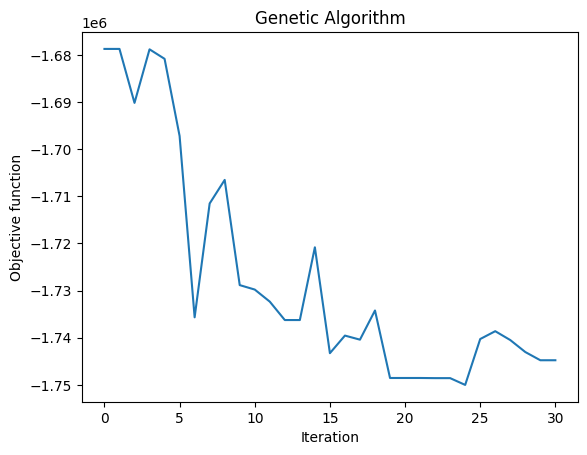


--- Optimale Parameter für drei Module ---
Modul 1: Neigung = 37°, Azimut = 201°
Modul 2: Neigung = 39°, Azimut = 194°
Modul 3: Neigung = 35°, Azimut = 184°
Kombinierter Gesamtertrag: 1,750,027.09 Wh


In [144]:
from geneticalgorithm import geneticalgorithm as ga

# Fitnessfunktion für drei Module (zu maximieren)
def fitness_function(params):
    # params = [neigung1, azimuth1, neigung2, azimuth2, neigung3, azimuth3]
    neigung1, azimuth1, neigung2, azimuth2, neigung3, azimuth3 = params

    # Solarertrag für Modul 1
    ertrag1 = optimize_solar_yield(
        df.copy(),
        balkonkraftwerk_tilt=int(neigung1),
        balkonkraftwerk_azimuth=int(azimuth1),
        balkonkraftwerk_fläche=balkonkraftwerk_fläche,
        balkonkraftwerk_wirkungsgrad=balkonkraftwerk_wirkungsgrad
    )

    # Solarertrag für Modul 2
    ertrag2 = optimize_solar_yield(
        df.copy(),
        balkonkraftwerk_tilt=int(neigung2),
        balkonkraftwerk_azimuth=int(azimuth2),
        balkonkraftwerk_fläche=balkonkraftwerk_fläche,
        balkonkraftwerk_wirkungsgrad=balkonkraftwerk_wirkungsgrad
    )

    # Solarertrag für Modul 3
    ertrag3 = optimize_solar_yield(
        df.copy(),
        balkonkraftwerk_tilt=int(neigung3),
        balkonkraftwerk_azimuth=int(azimuth3),
        balkonkraftwerk_fläche=balkonkraftwerk_fläche,
        balkonkraftwerk_wirkungsgrad=balkonkraftwerk_wirkungsgrad
    )

    # Kombinierter Ertrag (zu maximieren)
    return -(ertrag1 + ertrag2 + ertrag3)  # Negativ, weil GA minimiert

# Variablengrenzen für drei Module
varbound = np.array([
    [0, 50],   # Neigung Modul 1 (0–50°)
    [0, 360],  # Azimut Modul 1 (0–360°)
    [0, 50],   # Neigung Modul 2 (0–50°)
    [0, 360],  # Azimut Modul 2 (0–360°)
    [0, 50],   # Neigung Modul 3 (0–50°)
    [0, 360]   # Azimut Modul 3 (0–360°)
])

# Variablentyp als NumPy-Array (6 Integer-Variablen)
vartype = np.array(['int', 'int', 'int', 'int', 'int', 'int'], dtype=object)

# Algorithmusparameter (mit elit_ratio=0 für Kompatibilität)
algorithm_param = {
    'max_num_iteration': 30,
    'population_size': 225,
    'mutation_probability': 0.2,
    'crossover_probability': 0.7,
    'parents_portion': 0.3,
    'crossover_type': 'uniform',
    'max_iteration_without_improv': 20,
    'elit_ratio': 0
}

# Modell erstellen und ausführen (dimension=6 für drei Module)
model = ga(
    function=fitness_function,
    dimension=6,  # 6 Variablen: 3 Module × (Neigung + Azimut)
    variable_type_mixed=vartype,
    variable_boundaries=varbound,
    algorithm_parameters=algorithm_param
)

model.run()

# Ergebnis extrahieren
best_params = model.output_dict['variable']
best_neigung1, best_azimuth1, best_neigung2, best_azimuth2, best_neigung3, best_azimuth3 = map(int, best_params)
best_ertrag = -model.output_dict['function']

# Ausgabe
print("\n--- Optimale Parameter für drei Module ---")
print(f"Modul 1: Neigung = {best_neigung1}°, Azimut = {best_azimuth1}°")
print(f"Modul 2: Neigung = {best_neigung2}°, Azimut = {best_azimuth2}°")
print(f"Modul 3: Neigung = {best_neigung3}°, Azimut = {best_azimuth3}°")
print(f"Kombinierter Gesamtertrag: {best_ertrag:,.2f} Wh")

# Optional: Konvergenzplot
if 'convergence_curve' in model.output_dict:
    import matplotlib.pyplot as plt
    plt.plot(-np.array(model.output_dict['convergence_curve']), label='Beste Fitness')
    plt.xlabel('Iteration')
    plt.ylabel('Solarertrag (Wh)')
    plt.title('Konvergenz des genetischen Algorithmus (3 Module)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
from sklearn.model_selection import ParameterGrid
import pandas as pd
from tqdm import tqdm

# 1. Definiere die Parameter mit reduzierter Schrittweite
param_grid = {
    'tilt_1': range(35, 43, 1),      # Neigung Modul 1: 35°, 37°, ..., 50° (9 Werte)
    'azimuth_1': range(180, 200, 2), # Azimut Modul 1: 140°, 145°, ..., 220° (17 Werte)
    'tilt_2': range(35, 43, 1),      # Neigung Modul 2
    'azimuth_2': range(180, 200, 2), # Azimut Modul 2
    'tilt_3': range(35, 43, 1),      # Neigung Modul 3
    'azimuth_3': range(180, 200, 2)  # Azimut Modul 3
}

# 2. Leere Liste für die Ergebnisse
results = []

# 3. Durchläufe alle Kombinationen (ca. 1 Mio. Iterationen)
for params in tqdm(ParameterGrid(param_grid), total=len(list(ParameterGrid(param_grid)))):
    # Berechne Solarertrag für jedes Modul
    ertrag1 = optimize_solar_yield(
        df.copy(),
        balkonkraftwerk_tilt=params['tilt_1'],
        balkonkraftwerk_azimuth=params['azimuth_1'],
        balkonkraftwerk_fläche=balkonkraftwerk_fläche,
        balkonkraftwerk_wirkungsgrad=balkonkraftwerk_wirkungsgrad
    )
    ertrag2 = optimize_solar_yield(
        df.copy(),
        balkonkraftwerk_tilt=params['tilt_2'],
        balkonkraftwerk_azimuth=params['azimuth_2'],
        balkonkraftwerk_fläche=balkonkraftwerk_fläche,
        balkonkraftwerk_wirkungsgrad=balkonkraftwerk_wirkungsgrad
    )
    ertrag3 = optimize_solar_yield(
        df.copy(),
        balkonkraftwerk_tilt=params['tilt_3'],
        balkonkraftwerk_azimuth=params['azimuth_3'],
        balkonkraftwerk_fläche=balkonkraftwerk_fläche,
        balkonkraftwerk_wirkungsgrad=balkonkraftwerk_wirkungsgrad
    )

    # Speichere die Kombination und den Gesamtertrag
    results.append({
        'tilt_1': params['tilt_1'],
        'azimuth_1': params['azimuth_1'],
        'tilt_2': params['tilt_2'],
        'azimuth_2': params['azimuth_2'],
        'tilt_3': params['tilt_3'],
        'azimuth_3': params['azimuth_3'],
        'Gesamtertrag_Wh': ertrag1 + ertrag2 + ertrag3
    })

# 4. Erstelle DataFrame und finde die beste Kombination
df_results = pd.DataFrame(results)
best_combination = df_results.loc[df_results['Gesamtertrag_Wh'].idxmax()]

# 5. Ergebnisse anzeigen
print("\n--- Optimale Parameter für drei Module ---")
print(f"Modul 1: Neigung = {best_combination['tilt_1']}°, Azimut = {best_combination['azimuth_1']}°")
print(f"Modul 2: Neigung = {best_combination['tilt_2']}°, Azimut = {best_combination['azimuth_2']}°")
print(f"Modul 3: Neigung = {best_combination['tilt_3']}°, Azimut = {best_combination['azimuth_3']}°")
print(f"Kombinierter Gesamtertrag: {best_combination['Gesamtertrag_Wh']:,.2f} Wh")

# Optional: Validierung der besten Kombination
print("\n--- Validierung ---")
ertrag1 = optimize_solar_yield(
    df.copy(), best_combination['tilt_1'], best_combination['azimuth_1'],
    balkonkraftwerk_fläche, balkonkraftwerk_wirkungsgrad
)
ertrag2 = optimize_solar_yield(
    df.copy(), best_combination['tilt_2'], best_combination['azimuth_2'],
    balkonkraftwerk_fläche, balkonkraftwerk_wirkungsgrad
)
ertrag3 = optimize_solar_yield(
    df.copy(), best_combination['tilt_3'], best_combination['azimuth_3'],
    balkonkraftwerk_fläche, balkonkraftwerk_wirkungsgrad
)
print(f"Modul 1: {ertrag1:,.2f} Wh")
print(f"Modul 2: {ertrag2:,.2f} Wh")
print(f"Modul 3: {ertrag3:,.2f} Wh")
print(f"Summe: {ertrag1 + ertrag2 + ertrag3:,.2f} Wh")


100%|██████████| 512000/512000 [31:35<00:00, 270.06it/s]



--- Optimale Parameter für drei Module ---
Modul 1: Neigung = 41.0°, Azimut = 188.0°
Modul 2: Neigung = 41.0°, Azimut = 188.0°
Modul 3: Neigung = 41.0°, Azimut = 188.0°
Kombinierter Gesamtertrag: 1,757,226.39 Wh

--- Validierung ---
Modul 1: 585,742.13 Wh
Modul 2: 585,742.13 Wh
Modul 3: 585,742.13 Wh
Summe: 1,757,226.39 Wh


In [149]:
optimize_solar_yield(df,
                       balkonkraftwerk_tilt=39,
                       balkonkraftwerk_azimuth=191,
                       balkonkraftwerk_fläche=balkonkraftwerk_fläche,
                       balkonkraftwerk_wirkungsgrad=balkonkraftwerk_wirkungsgrad,)

585489.6464391742